# Quick Demo
I'll use this doc to briefly demo the code. 

Let's begin by loading the libraries we'll need.

In [2]:
import GPy
import sys
import os
sys.path.append(os.getenv("HOME") + "/Documents/Code/Emulation/GPyDifferentMetrics/")
from HaversineDist import Exponentialhaversine
import numpy as np
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import glob as glob
from cmocean import cm as cm
from Utilities import *


Now let's specify where the data and model runs are located, and load them.

In [3]:

GCM_dir = os.getenv("HOME")+'/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/'
gcm_SSTs = glob.glob(GCM_dir+'t*.txt')

gcm_mask = np.genfromtxt(GCM_dir+'mask.txt', dtype='int')

obs_dir = os.getenv("HOME")+'/Documents/Code/ModelDataComparison/DMC/Scripts/Observation_data/P3+_SST_anom/'
file = 'lambda_10.txt'
observations = np.genfromtxt(obs_dir+file, skip_header=1)


We'll extract the observations into their coordinates (long and lat) which I'll refer to as X, the measurement (Y), and our estimate of the ratio of the variance of the measurement error at each point (NOTE: I was unsure whether the numbers in the data you gave me were supposed to standard deviations or variances - they look like std devs, so I've squared them). Note that all that matters is the relative size of these variances (their ratio). We need to try changing this to find its effect.

I've plotted the locations just as a check.

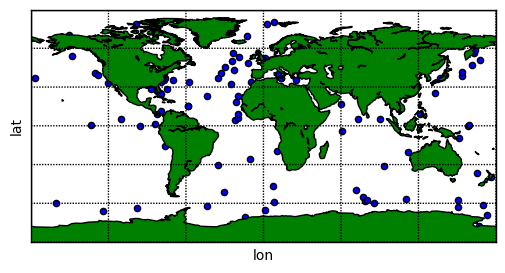

In [4]:
X_obs = observations[:,0:2]
y_obs = observations[:,2].reshape(-1,1)
var_ratios = observations[:,3][:,None]**2
map = plot_map(X_obs=X_obs)


## Fitting a Gaussian process model



In [5]:

from scaledheteroscedasticgaussian import ScaledHeteroscedasticGaussian
from gp_heteroscedastic_ratios import ScaledHeteroscedasticRegression


k3 = Exponentialhaversine(2, lengthscale=2000)
m3 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k3, noise_mult=1., 
                                     known_variances=var_ratios)
m3.optimize_restarts(10)


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 202.7394228954263
Optimization restart 2/10, f = 256.53567524840105
Optimization restart 3/10, f = 256.53568105882647
Optimization restart 4/10, f = 256.5356754259651
Optimization restart 5/10, f = 256.5356746918563
Optimization restart 6/10, f = 256.53568088990994
Optimization restart 7/10, f = 230.29148806663764
Optimization restart 8/10, f = 230.29148806666336
Optimization restart 9/10, f = 230.29148806848082
Optimization restart 10/10, f = 256.5356881319677



Name : gp
Objective : 202.7394228954263
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |  9.72822417707  |      +ve      |        
  Exponential.lengthscale      |  4778.83030186  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  7.99632407141  |      +ve      |        


 /Users/pmzrdw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:91: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


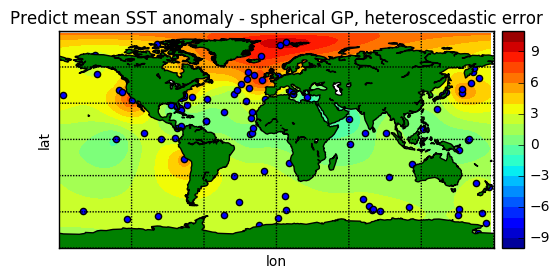

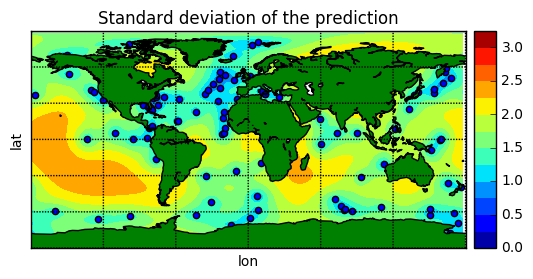

In [7]:
print(m3)
latsplot = np.arange(-90.0,90.0, 2.5)
longsplot = np.arange(-180.0,180.0, 2.5)
longgridplot, latgridplot = np.meshgrid(longsplot, latsplot)
X_plot=np.column_stack((longgridplot.flatten(), latgridplot.flatten())) # specifies the prediction locations

mu3,V3 = m3.predict_noiseless(X_plot)


plt.figure(3)
map=plot_map(longgridplot, latgridplot, mu3, X_obs)
plt.title('Predict mean SST anomaly - spherical GP, heteroscedastic error')

plt.figure(4)
map=plot_map(longgridplot, latgridplot, np.sqrt(V3), X_obs, levels=np.arange(0,np.sqrt(V3).max()+1,0.25))
plt.title('Standard deviation of the prediction')

## Likelihood calculations

Let's now evaluate the 8 GCM simulations we have available. To do this, we need to predict the GCM output at every grid cell, and then evalaute the probability of seeing this value under our GP model fitted to the observational data.

We'll begin by loading the GCM runs

In [8]:
count=0
gcm_runs = np.zeros((8,27186))
gcm_runs_label = gcm_SSTs.copy()

for file_name in gcm_SSTs:
    file_nm = file_name.split(GCM_dir)[-1]
    print(file_nm)
    # Read in GCM output.
    gcm_runs[count,:] = np.genfromtxt(file_name)
    gcm_runs_label[count] = file_nm.split(".txt")[0]
    count +=1

    
# Create the prediction grid - removing the land coordinates to save computation effort.
X_pred, out = ThinGrid(gcm_runs[0,:], gcm_mask, thinby=1)

tczyi.txt
tczyj.txt
tczyk.txt
tdgtg.txt
tdgth.txt
tdgti.txt
tdgtj.txt
tdgtk.txt


Let's predict on the grid, and compute the Cholesky decomposition of the covariance matrix

In [9]:
mu, Cov = m3.predict_noiseless(X_pred, full_cov=True)
Chol = np.linalg.cholesky(Cov)

In [10]:
from Cholesky import *
loglikes = dlogmvnorm(gcm_runs.T, mu, Chol)
orderings = np.argsort(-loglikes) #minus sign so that max is first
relative = np.round(loglikes-np.max(loglikes),1)


We can decode from the file names to the CO2 values to this to see how this ranks the various GCM runs.

In [12]:
dict = {'tdgth': '280 ppm',
        'tczyi': '315 ppm',
    'tdgtj': '350 ppm',
    'tczyj': '375 ppm',
    'tdgtg': '405 ppm',
    'tczyk': '475 ppm',
    'tdgtk': '560 ppm',
    'tdgti': '1000 ppm'}

for ii in range(8):
    print(dict[gcm_runs_label[orderings[ii]]] + ':  relative loglike = '+str(relative[orderings[ii]]))

280 ppm:  relative loglike = 0.0
315 ppm:  relative loglike = -156.4
350 ppm:  relative loglike = -329.8
375 ppm:  relative loglike = -439.2
405 ppm:  relative loglike = -746.7
475 ppm:  relative loglike = -1147.6
560 ppm:  relative loglike = -1445.2
1000 ppm:  relative loglike = -3950.4


Let's plot the GCM runs in order of their log-likelihood ranking.

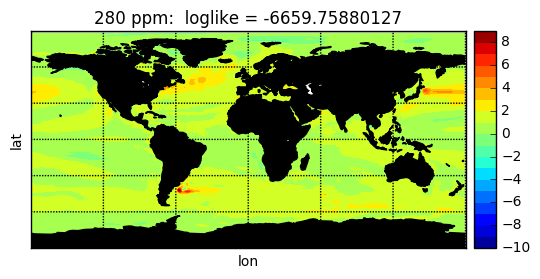

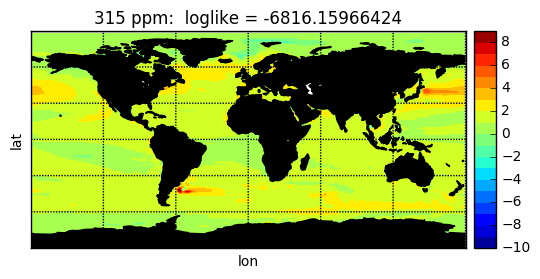

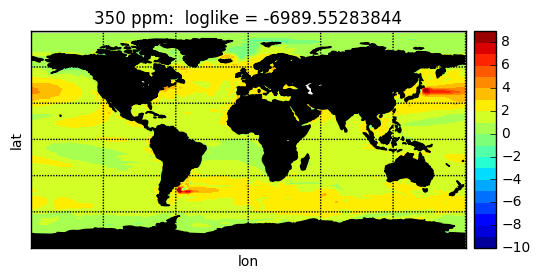

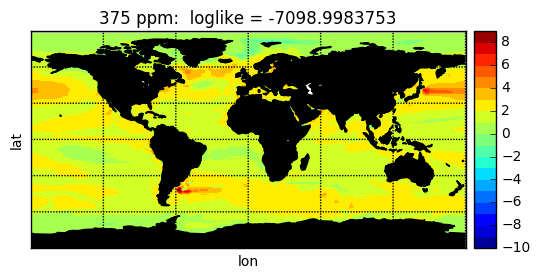

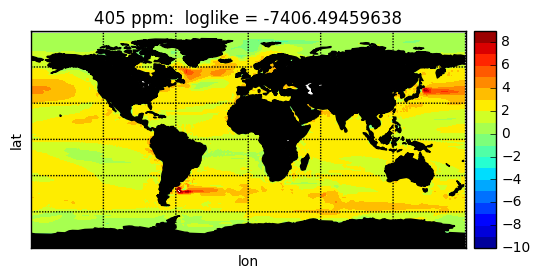

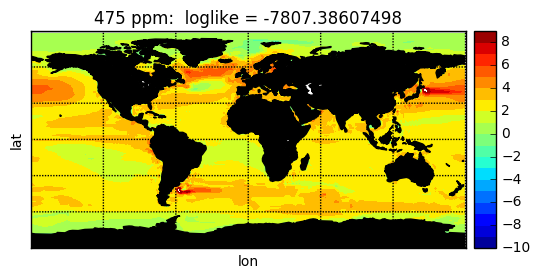

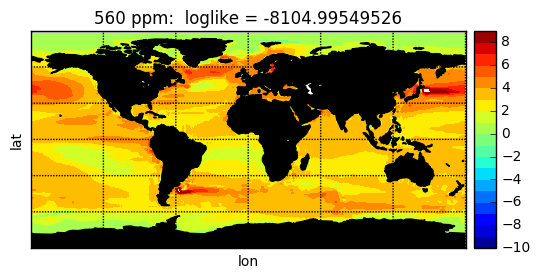

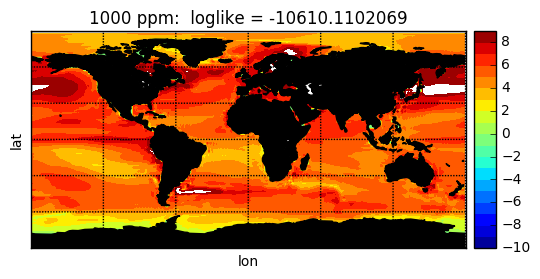

In [13]:
for ii in range(8):
    plt.figure()
    map = plot_gcm(gcm_runs[orderings[ii],:], gcm_mask)
    plt.title(dict[gcm_runs_label[orderings[ii]]]+ ':  loglike = '+ str(loglikes[orderings[ii]]))
#    plt.title(loglikes[ii]+': log-likelihood = ' + str(round(float(loglike_results[ii,0]),1)))